In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Загрузка изображений и масок
# image_dir = 'images/'
# mask_dir = 'masks/'

# images = sorted(glob.glob('/content/drive/MyDrive/gas_seg/3_class_images/*.PNG'))
# masks = sorted(glob.glob('/content/drive/MyDrive/gas_seg/3_class_masks_new/*.png'))

# images = sorted(glob.glob('/content/drive/MyDrive/gas_seg/test/images/*.PNG'))
# masks = sorted(glob.glob('/content/drive/MyDrive/gas_seg/test/masks/*.png'))

image_dir = '/content/drive/MyDrive/gas_seg/test/images/'
mask_dir = '/content/drive/MyDrive/gas_seg/test/masks/'

In [ ]:
# image_filenames = os.listdir(image_dir)
# mask_filenames = os.listdir(mask_dir)

# images = []
# masks = []

# for img_filename in image_filenames:
#     img = cv2.imread(os.path.join(image_dir, img_filename))
#     images.append(img)

# for mask_filename in mask_filenames:
#     mask = cv2.imread(os.path.join(mask_dir, mask_filename), cv2.IMREAD_GRAYSCALE)
#     masks.append(mask)


# # Меняем размерность изображений и масок на 256 на 256
# new_size = (256, 256)
# imgs_resized = []
# masks_resized = []
# for img, mask in zip(images, masks):
#     img_resized = cv2.resize(img, new_size)
#     mask_resized = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)
#     imgs_resized.append(img_resized)
#     masks_resized.append(mask_resized)

# # Увеличиваем количество примеров в 2 раз
# number = 2
# imgs_resized = imgs_resized * number
# masks_resized = masks_resized * number


# # Разделение на тренировочную и тестовую выборки
# data = list(zip(imgs_resized, masks_resized))
# random.shuffle(data)

# train_data = data[:int(len(data)*0.8)]
# test_data = data[int(len(data)*0.8):]

# print(len(imgs_resized))
# print(len(train_data))
# print(len(test_data))

42
29
13


In [ ]:
# for i in range(0,5):
#   fig, ax = plt.subplots(figsize=(8,4), ncols=2, nrows=1)

#   ax[0].imshow(imgs_resized[i])
#   ax[1].imshow(masks_resized[i])

В этом коде мы создаем два генератора: для изображений и для масок. Параметр rescale в генераторе для изображений используется для нормализации значений пикселей. Параметр validation_split задает долю данных, которые будут использоваться для валидации модели. Затем мы загружаем изображения и маски с помощью метода flow_from_directory(). Параметр subset в этом методе позволяет выбрать часть данных для обучения или валидации в зависимости от того, какой генератор мы используем.

Далее мы объединяем изображения и маски в один генератор train_data и val_data с помощью функции zip(), которая позволяет объединить несколько последовательностей в одну.

ImageDataGenerator - это класс из библиотеки Keras, который позволяет автоматически генерировать увеличенные выборки изображений путем применения различных преобразований к исходным изображениям, таким как изменение размера, поворот, сдвиг, отражение, изменение яркости и т.д. Это может помочь увеличить разнообразие и количество примеров для обучения модели, что может привести к лучшим результатам при обучении моделей компьютерного зрения. ImageDataGenerator также может использоваться для создания генераторов данных, которые могут быть использованы в Keras моделях при обучении с помощью метода fit_generator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dir = '/content/drive/MyDrive/gas_seg/test/images/'
mask_dir = '/content/drive/MyDrive/gas_seg/test/masks/'
SEED = 12345
BATCH_SIZE = 1

# Создание генератора для изображений
image_datagen = ImageDataGenerator(
    rescale=1./255,  # Нормализация значений пикселей
    validation_split=0.3,  # Деление на обучающую и валидационную выборки
    # rotation_range=90,  # Случайные повороты в диапазоне от -90 до 90 градусов
    # width_shift_range=0.1,  # Случайные горизонтальные сдвиги в диапазоне от -0.1 до 0.1 от ширины изображения
    # height_shift_range=0.1,  # Случайные вертикальные сдвиги в диапазоне от -0.1 до 0.1 от высоты изображения
    # shear_range=0.1,  # Случайные сдвиги вдоль оси x и y в диапазоне от -0.1 до 0.1 от угла сдвига
    # zoom_range=0.1,  # Случайный зум в диапазоне от 0.9 до 1.1
    # horizontal_flip=True,  # Случайный поворот по горизонтали
    # vertical_flip=True  # Случайный поворот по вертикали
)

# Создание генератора для масок
mask_datagen = ImageDataGenerator(
    validation_split=0.3,
    # rotation_range=90,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # vertical_flip=True
)


# Загрузка изображений и масок
train_images = image_datagen.flow_from_directory(
    image_dir,
    target_size=(256, 256),
    color_mode="rgb",
    class_mode=None,
    batch_size=BATCH_SIZE,
    subset="training",
    # save_to_dir=image_dir,
    # save_prefix="aug",
    # save_format="png",
    # shuffle=True,
    seed=SEED
)

train_masks = mask_datagen.flow_from_directory(
    mask_dir,
    target_size=(256, 256),
    color_mode="grayscale",
    class_mode=None,
    batch_size=BATCH_SIZE,
    subset="training",
    # save_to_dir=mask_dir,
    # save_prefix="aug",
    # save_format="png",
    # shuffle=True,
    seed=SEED
)

val_images = image_datagen.flow_from_directory(
    image_dir,
    target_size=(256, 256),
    color_mode="rgb",
    class_mode=None,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=SEED
)

val_masks = mask_datagen.flow_from_directory(
    mask_dir,
    target_size=(256, 256),
    color_mode="grayscale",
    class_mode=None,
    batch_size=BATCH_SIZE,
    subset="validation",
    seed=SEED
)

# Объединение изображений и масок в один генератор
train_data = zip(train_images, train_masks)
val_data = zip(val_images, val_masks)

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


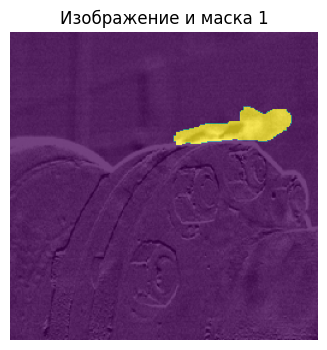

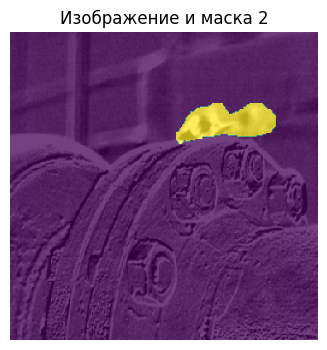

In [ ]:
# Картинки в 1 столбец
for num in range(len(train_images)):
  plt.figure(figsize=(8,4))
  plt.imshow(train_images[num][0])
  plt.imshow(train_masks[num][0] ,alpha=0.75)
  
  plt.title(f'Изображение и маска {num+1}')
  plt.axis('off')

  plt.show()

# Картинки в 2 столбца
# for num in range(len(train_images)):
#   fig, ax = plt.subplots(figsize=(8,4), ncols=2, nrows=1)

#   ax[0].imshow(train_images[num][0])
#   ax[0].get_xaxis().set_visible (False)
#   ax[0].get_yaxis().set_visible (False)
#   ax[0].set_title(f'Изображение {num}')

#   ax[1].imshow(train_masks[num][0])
#   ax[1].get_xaxis().set_visible (False)
#   ax[1].get_yaxis().set_visible (False)
#   ax[1].set_title(f'Маска {num}')

Если у вас мало обучающих данных, то можно использовать техники аугментации данных для увеличения их количества. Аугментация данных - это процесс искусственного увеличения размера обучающего набора данных путем создания измененных копий исходных изображений и масок.

Например, можно использовать следующие методы аугментации:

  - поворот изображения на случайный угол;
  - зеркальное отражение изображения по горизонтали или вертикали;
  - случайное изменение яркости, контрастности и насыщенности цветов изображения;
  - случайное изменение размера исходного изображения;
  - добавление шума к изображению.

Также можно использовать технику Transfer Learning, когда модель предобучена на большом наборе данных, а затем дообучена на вашем наборе данных. Это может помочь увеличить точность модели на малом наборе данных.

In [ ]:
# Создание и обучение модели UNet
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# X_train = np.array([img for img, mask in train_data])
# y_train = np.array([mask for img, mask in train_data])

# X_test = np.array([img for img, mask in val_data])
# y_test = np.array([mask for img, mask in val_data])

# X_test = np.array([img for img, mask in test_data])
# y_test = np.array([mask for img, mask in test_data])

# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)

In [ ]:
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_46[0][0]']              
                                )                                                           

In [ ]:
# Определение пути для сохранения модели
# model_checkpoint = ModelCheckpoint('best_model.h5', 
#                                     monitor='val_loss', 
#                                     mode='min', 
#                                     save_best_only=True, 
#                                     verbose=1)

# Создание EarlyStopping Callback
# Остановка обучения, если метрика на валидационной выборке перестает улучшаться
early_stopping = EarlyStopping(
                        monitor='val_loss', # Метрика для отслеживания (в данном случае функция потерь на валидационной выборке)
                        patience=5, # Количество эпох без улучшения, после которых обучение остановится
                        verbose=1, # Вывод сообщений об остановке обучения
                        mode='min' # Режим отслеживания метрики (в данном случае минимизация функции потерь)
                    )

# Список callback'ов, которые будут вызваны во время обучения модели
callbacks = [early_stopping]

history = model.fit(train_data, 
                    validation_data=(val_data), 
                    batch_size=1, 
                    steps_per_epoch=len(train_images),
                    epochs=10)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=20)

In [ ]:
# Сохраняем модель в файл
# model.save('/content/drive/MyDrive/gas_seg/my_model.h5')

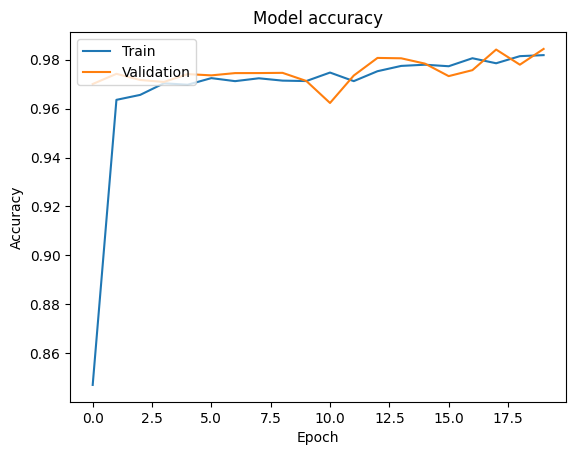

In [ ]:
# Выводим график accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

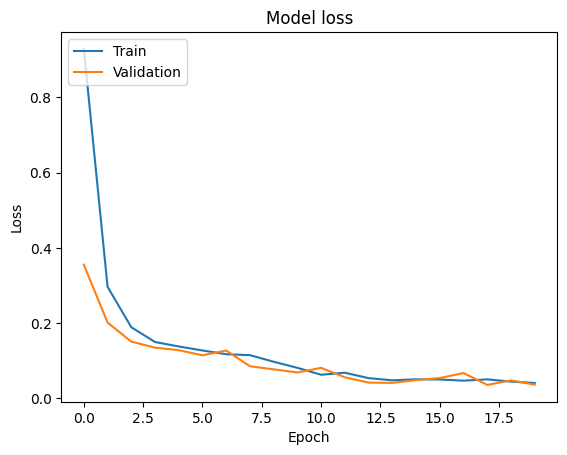

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

kernel_initializer - это параметр в модели нейронной сети, который определяет стратегию инициализации весов (ядер) сверточных и полносвязных слоев модели.

Инициализация весов - это процесс установки начальных значений для весов в нейронной сети перед обучением. Это важный этап, так как начальные значения весов могут существенно влиять на скорость сходимости обучения и на качество решений модели.

kernel_initializer может принимать различные значения, например:

  - "glorot_uniform": использует стратегию инициализации Глорота, которая учитывает количество входов и выходов каждого слоя и случайным образом инициализирует веса с помощью равномерного распределения
  - "he_uniform": использует стратегию инициализации Хе, которая инициализирует веса с помощью равномерного распределения, учитывая количество входов в каждый нейрон
  - "lecun_uniform": использует стратегию инициализации Лекуна, которая инициализирует веса с помощью равномерного распределения, учитывая количество входов в каждый нейрон, но без учета выходов.

В целом, правильный выбор стратегии инициализации весов может ускорить сходимость модели и улучшить ее точность. В то же время, неправильный выбор стратегии инициализации может привести к проблемам с обучением, таким как затухание или взрыв градиентов.

In [ ]:
from keras.models import load_model

input_video = '/content/drive/MyDrive/gas_seg/test/test_video/MOV_3733.mp4'
output_video = '/content/drive/MyDrive/gas_seg/test/test_video/test.mp4'

# Сегментация классов на видео
def segment_video(input_filename, output_filename):
  cap = cv2.VideoCapture(input_filename)
  fps = cap.get(cv2.CAP_PROP_FPS)
  out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (320, 240))

  # Тут загрузить обученную модель
  # model = load_model('/content/drive/MyDrive/gas_seg/my_model.h5')

  while(cap.isOpened()):
    ret, frame = cap.read()

    if ret == True:
        resized_frame = cv2.resize(frame, (256, 256))
        mask = model.predict(np.array([resized_frame]))[0]
        mask = cv2.resize(mask, (320, 240))

        # fig, ax = plt.subplots(figsize=(15,8), ncols=2, nrows=1)
        # ax[0].imshow(frame)
        # ax[1].imshow(mask)
        # plt.show()

        mask = (mask > 0.5).astype(np.uint8)  # Преобразование в бинарную маску
        yellow_mask = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2RGB)  # Создание маски желтого цвета
        yellow_mask[:, :, :] = (200, 170, 26) * yellow_mask[:, :, :]  # Окрашивание маски в желтый цвет
        masked_frame = cv2.addWeighted(frame, 0.7, yellow_mask, 0.3, 0)  # Наложение маски на исходное изображение
        out.write(masked_frame)

        plt.figure(figsize=(8,4))
        plt.imshow(masked_frame)
        plt.show()
    else:
        break

  cap.release()
  out.release()

In [ ]:
segment_video(input_video, output_video)

1/1 [==============================] - 1s 916ms/step


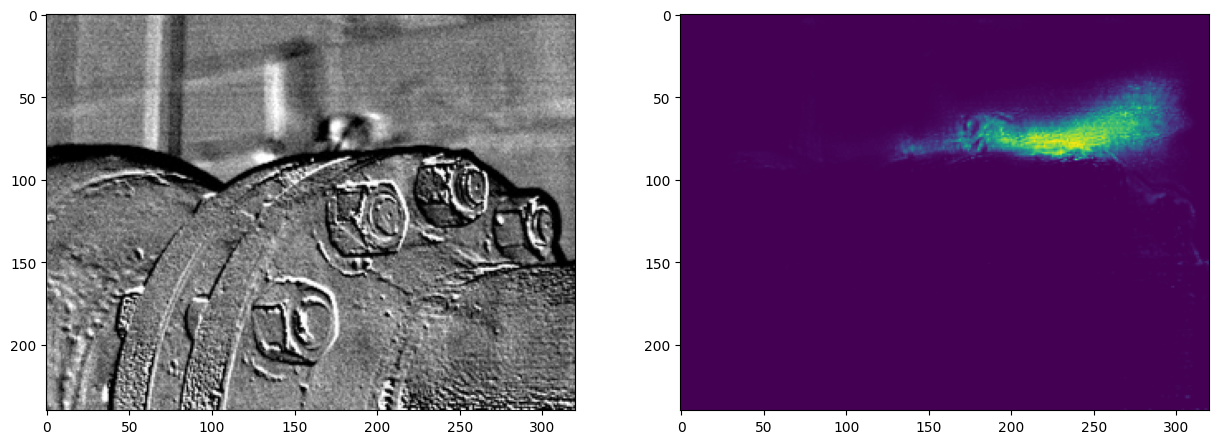

1/1 [==============================] - 1s 593ms/step


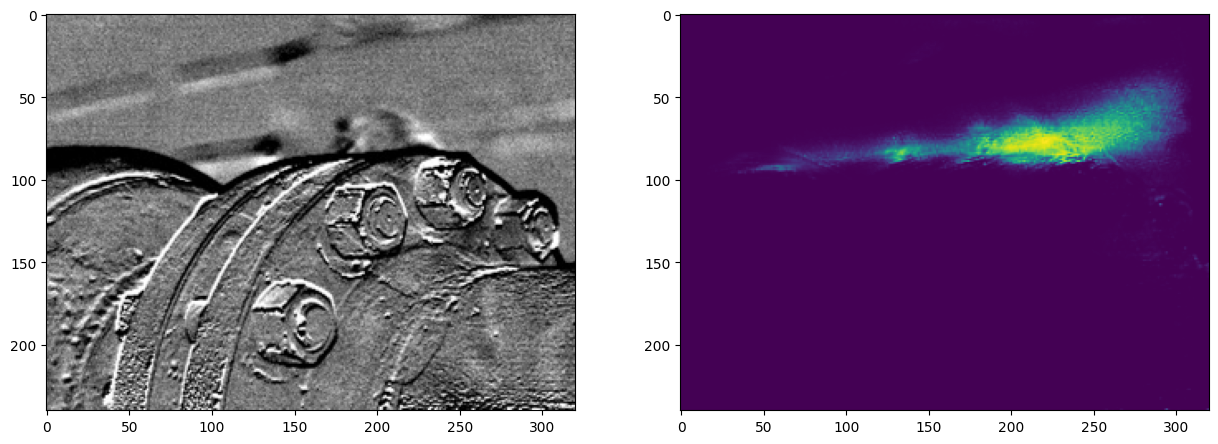

1/1 [==============================] - 1s 951ms/step


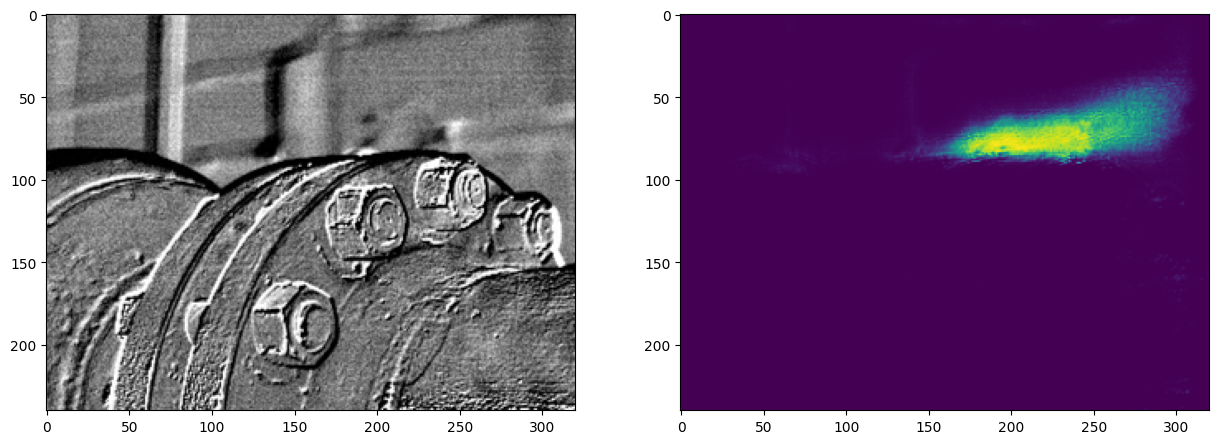

1/1 [==============================] - 1s 634ms/step


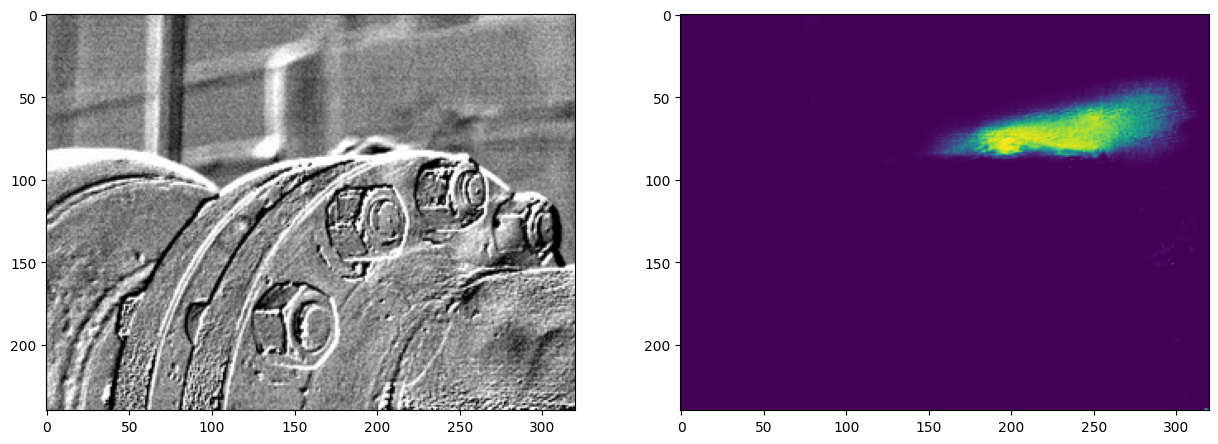

1/1 [==============================] - 1s 879ms/step


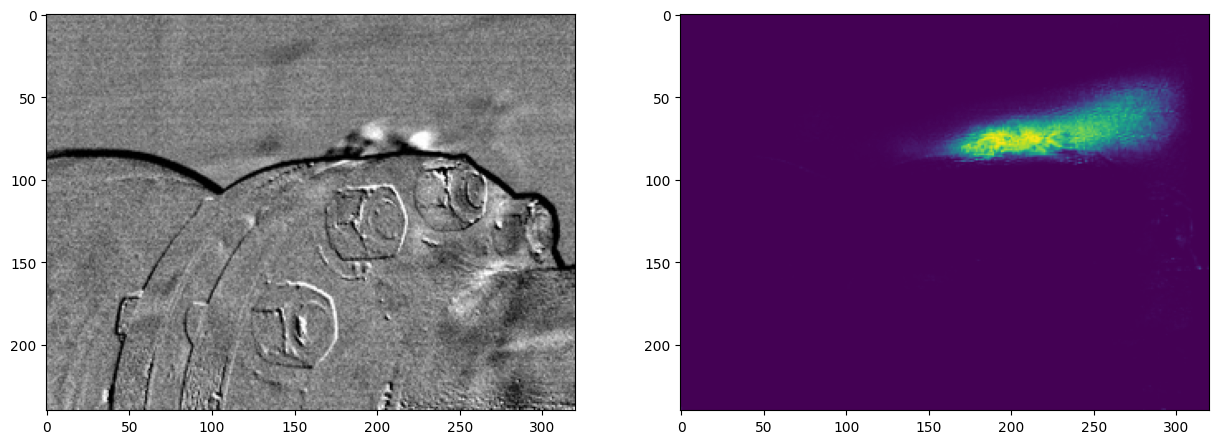

1/1 [==============================] - 1s 1s/step


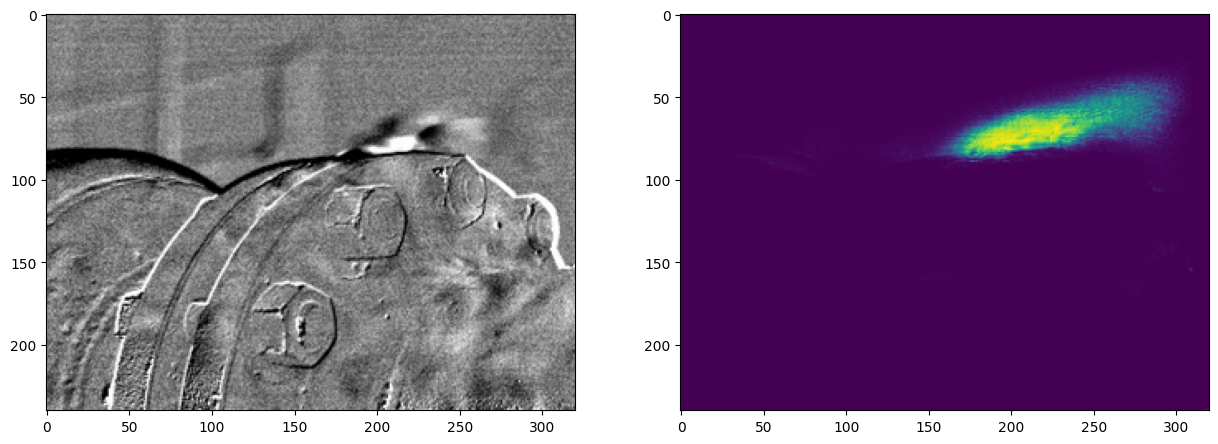

1/1 [==============================] - 1s 1s/step


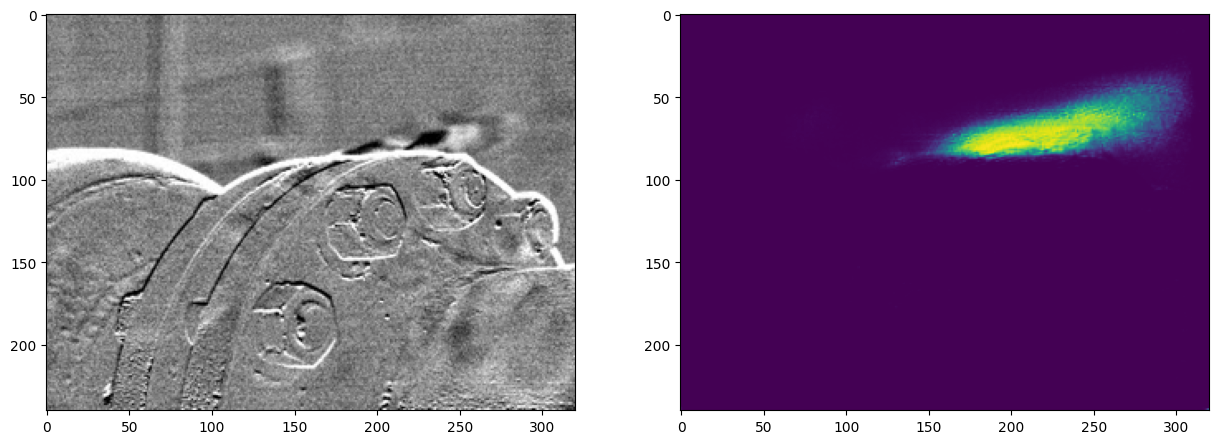

1/1 [==============================] - 1s 982ms/step


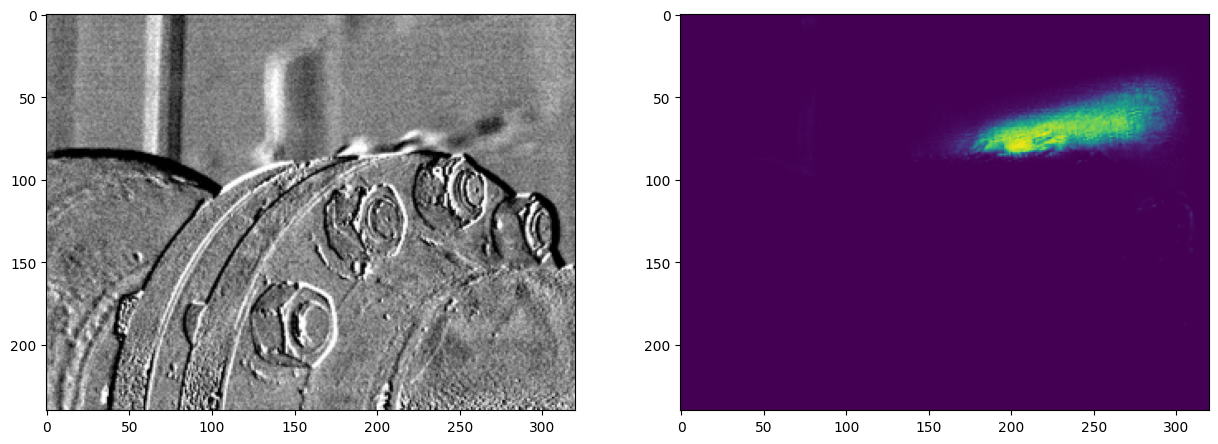

1/1 [==============================] - 1s 1s/step


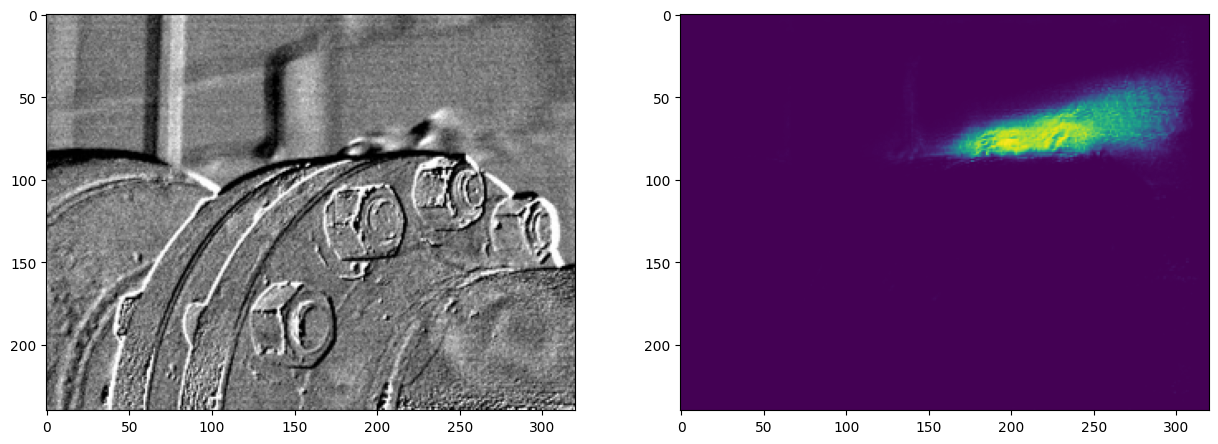

1/1 [==============================] - 1s 787ms/step


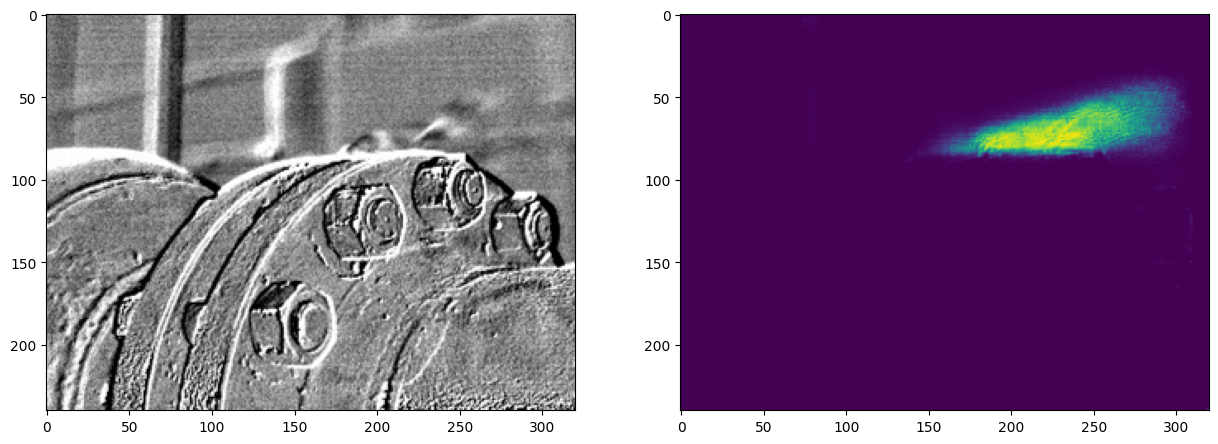

1/1 [==============================] - 1s 582ms/step


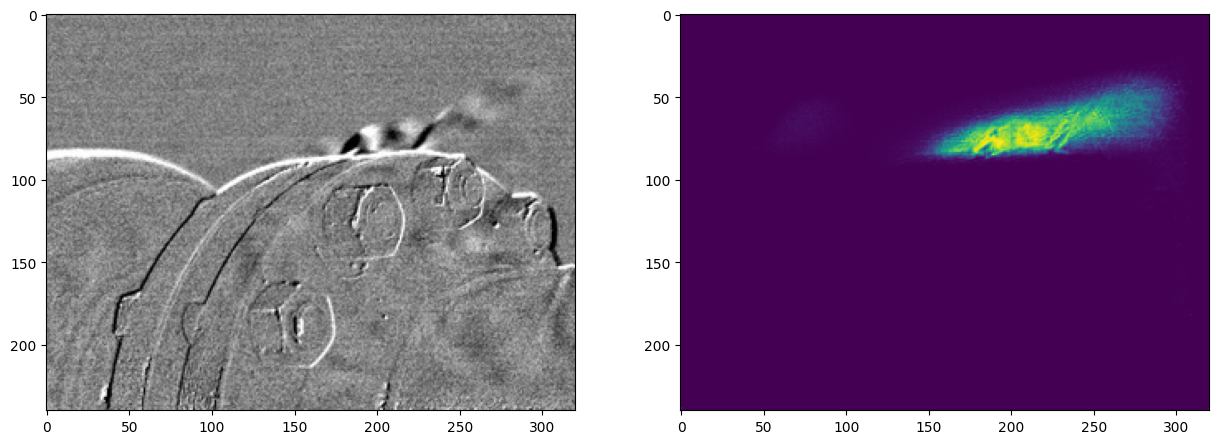

1/1 [==============================] - 1s 619ms/step


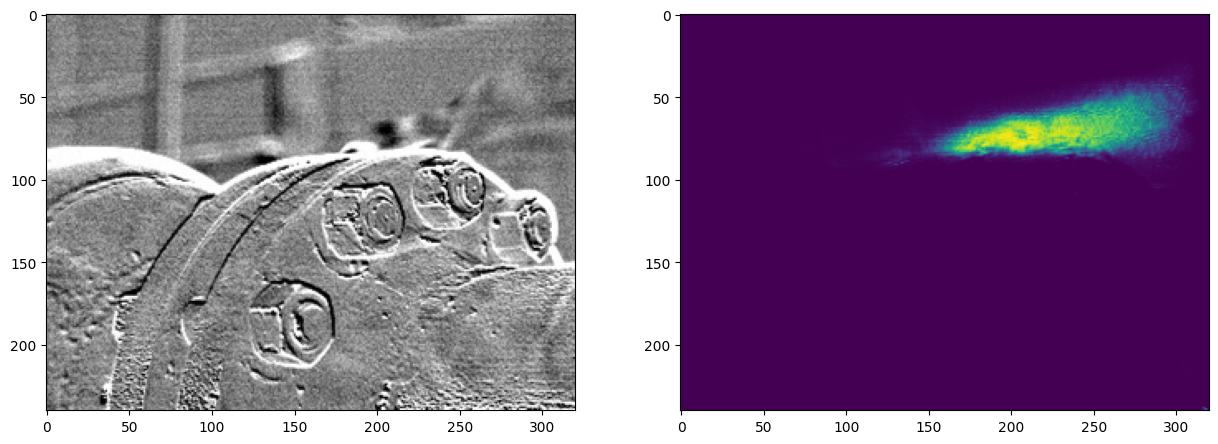

1/1 [==============================] - 1s 617ms/step


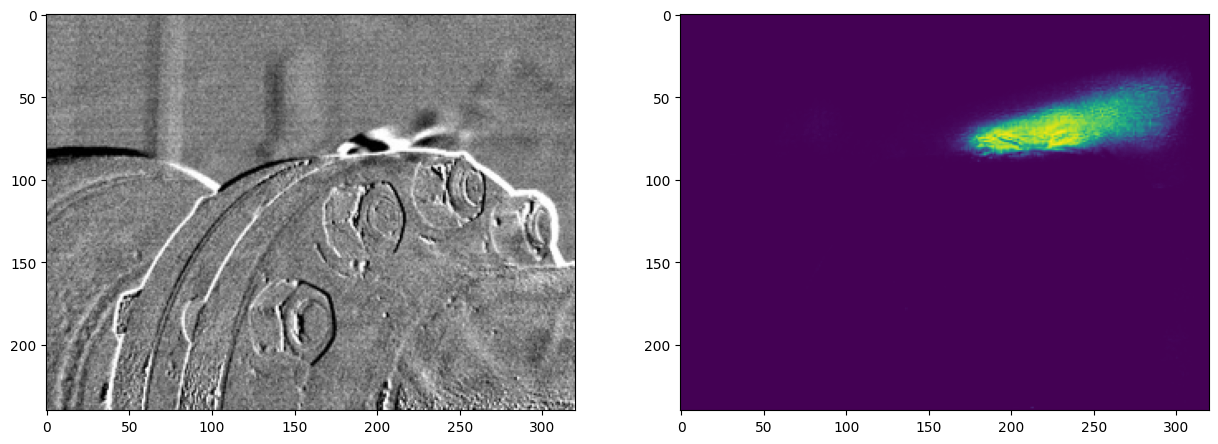

1/1 [==============================] - 1s 612ms/step


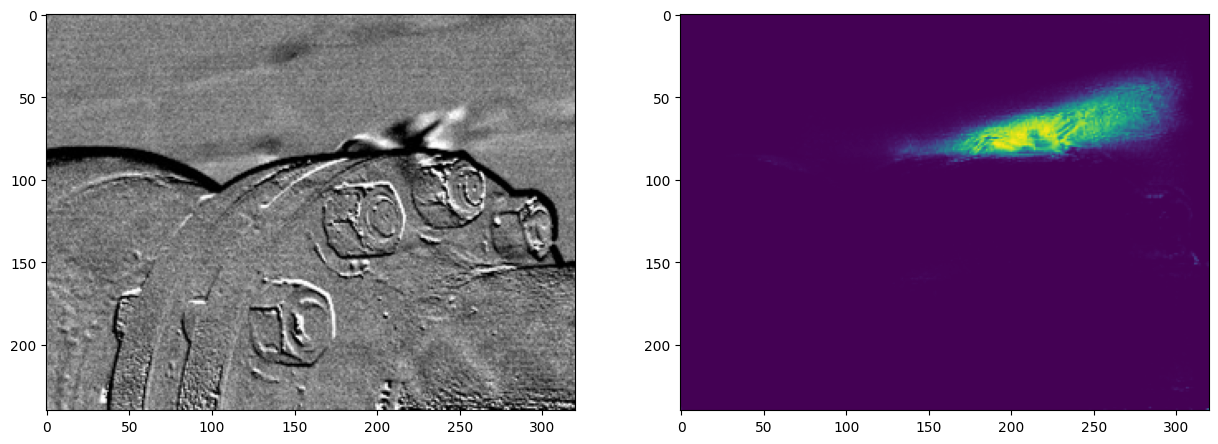

1/1 [==============================] - 1s 612ms/step


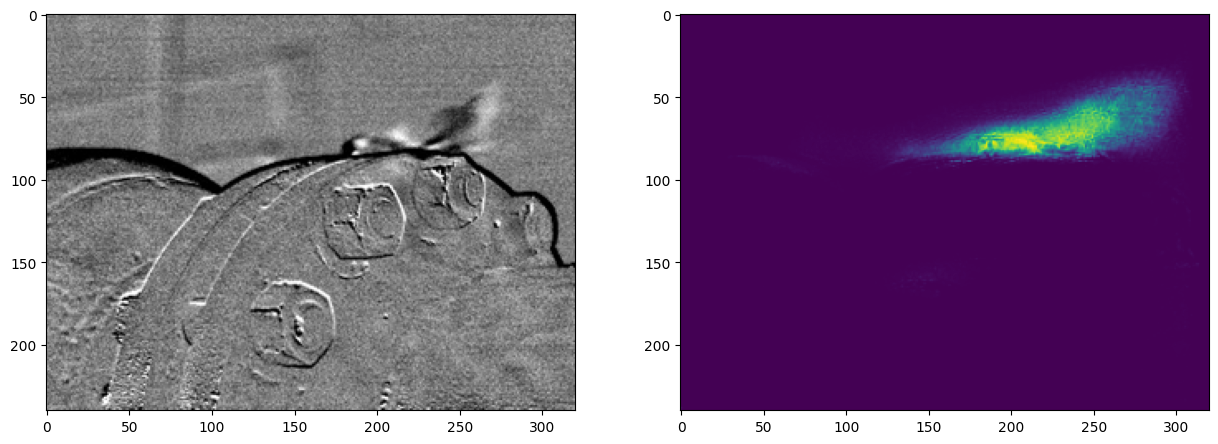

1/1 [==============================] - 1s 614ms/step


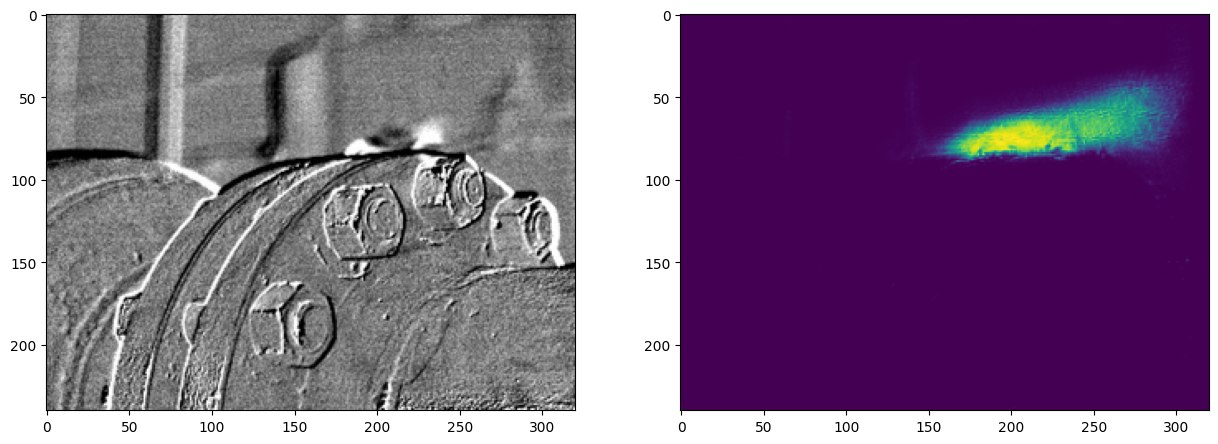

1/1 [==============================] - 1s 619ms/step


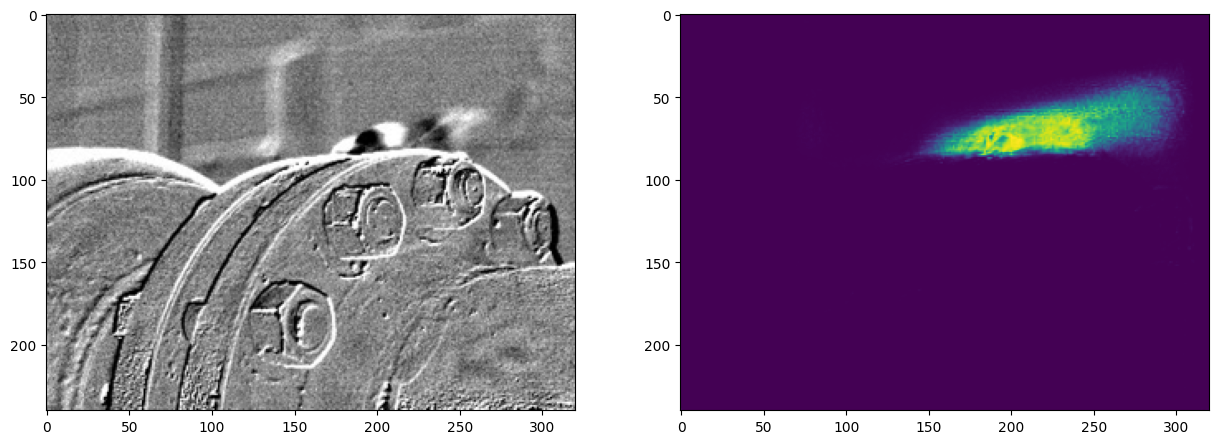

1/1 [==============================] - 1s 972ms/step


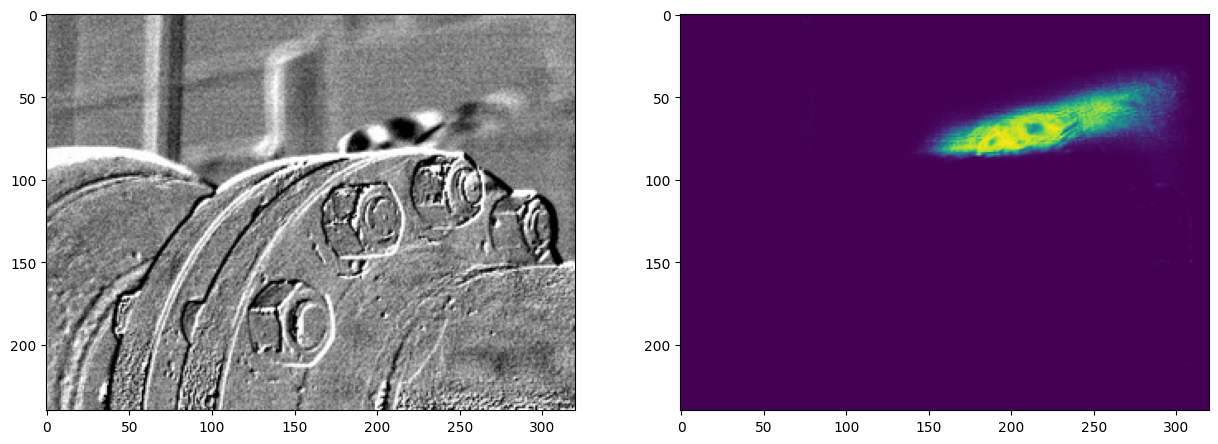

KeyboardInterrupt: ignored

In [ ]:
segment_video(input_video, output_video)

Функция segment_video использует натренированную модель UNet для сегментации классов на видео. Она принимает входное видео input_filename в формате mp4 и имя файла для сохранения сегментированного видео output_filename также в формате mp4.

Для каждого кадра видео, функция выполняет следующие действия:

  - Считывает кадр с помощью функции cv2.VideoCapture.read()
  - Изменяет размер кадра до 256х256 с помощью функции cv2.resize()
  - Прогнозирует маску объектов на изображении с помощью модели UNet с помощью функции model.predict()
  - Изменяет размер маски до размеров оригинального кадра с помощью функции cv2.resize()
  - Преобразует маску в значения 0 и 255, используя функцию np.uint8()
  - Применяет маску на оригинальный кадр с помощью функции cv2.bitwise_and()
  - Записывает сегментированный кадр в выходное видео с помощью функции cv2.VideoWriter.write()

Таким образом, функция segment_video позволяет сегментировать видео, используя модель, которую мы натренировали ранее, и сохранить сегментированное видео в файле.







Для сохранения обученной модели в Keras можно воспользоваться методом save() модели. Например, для сохранения модели в файле "my_model.h5" можно использовать следующий код:

In [ ]:
model.save("my_model.h5")

Затем, для загрузки сохраненной модели в функции segment_video(), можно воспользоваться методом load_model() модели, который загружает модель из указанного файла:

In [ ]:
from keras.models import load_model

def segment_video(model_path, video_path):
    model = load_model(model_path)
    # далее идет код для сегментации видео с помощью загруженной модели


В функции segment_video() мы загружаем модель с помощью load_model() из файла, указанного в аргументе model_path. После этого можем использовать загруженную модель для сегментации видео.

In [ ]:
# Код для создания функции сегментации видео с помощью обученной модели UNet:

import cv2
import numpy as np
from tensorflow.keras.models import load_model

def segment_video(model_path, video_path, output_path):
    # Загрузка обученной модели UNet
    model = load_model(model_path)
    
    # Определение размеров входных изображений модели UNet
    input_shape = model.layers[0].input_shape[1:3]
    
    # Загрузка видео
    cap = cv2.VideoCapture(video_path)
    
    # Получение размеров видео
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Создание объекта VideoWriter для записи результата в видеофайл
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))
    
    while(cap.isOpened()):
        # Чтение кадра видео
        ret, frame = cap.read()
        if ret == True:
            # Масштабирование изображения до размеров входных данных модели UNet
            resized_frame = cv2.resize(frame, input_shape, interpolation=cv2.INTER_AREA)
            
            # Нормализация значений пикселей
            normalized_frame = resized_frame.astype(np.float32) / 255.0
            
            # Применение модели UNet для получения маски сегментации
            mask = model.predict(np.array([normalized_frame]))[0]
            
            # Преобразование маски в бинарное изображение
            threshold = 0.5
            binary_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
            binary_mask[mask > threshold] = 255
            
            # Масштабирование бинарной маски до размеров исходного изображения
            scaled_mask = cv2.resize(binary_mask, (width, height), interpolation=cv2.INTER_NEAREST)
            
            # Наложение маски на кадр видео
            result_frame = cv2.bitwise_and(frame, frame, mask=scaled_mask)
            
            # Запись результата в видеофайл
            out.write(result_frame)
        else:
            break
            
    # Освобождение ресурсов
    cap.release()
    out.release()
    cv2.destroyAllWindows()


model_path = 'path/to/model.h5'
video_path = 'path/to/video.mp4'
output_path = 'path/to/output.mp4'

segment_video(model_path, video_path, output_path)
